In [10]:
import os
import numpy as np
from skimage.io import imread
from skimage.restoration import estimate_sigma
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from operator import itemgetter
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from pyoptflow import HornSchunck
from sklearn.neighbors import LocalOutlierFactor
from scipy import stat

ImportError: cannot import name 'stat' from 'scipy' (C:\Users\Hzhang\anaconda3\lib\site-packages\scipy\__init__.py)

In [73]:
def _get_measurements(folder):
    # list image files
    filenames = os.listdir(folder)
    # sort the image filenames
    filenames = sorted(filenames, key=lambda v: v.upper())
    nl, bs, bs2, ai, dl, di, cl, mz = [], [], [], [], [], [], [], []
    for filename in filenames:
        print(filename)
        filename = os.path.join(folder, filename)
        im = imread(filename)
        im = np.moveaxis(im, 0, -1)
        for i in range(im.shape[2]):
            nl.append(estimate_sigma(im[:, :, i], multichannel=False, average_sigmas=True))
            imlap = laplace(im[:, :, i])
            bs.append(imlap.var())  # Blurriness Score
            im2 = gaussian_filter(im[:, :, i], sigma=3)
            bs2.append(im2.var())  # Blurriness Score with Gaussian Filter
            ai.append(im[:, :, i].mean())  # Average Intensity
            dl.append(_get_dark_light(im[:, :, i]))  # Darkness Level
            di.append(_get_dominant_intensity(im[:, :, i]))  # Dominant intensity
            imgx, imgy = np.gradient(im[:, :, i])
            img = np.sqrt(np.power(imgx, 2) + np.power(imgy, 2))
            cl.append(np.sum(img) / (im.shape[0] * im.shape[1]))  # Contrast Level
        for i in range(im.shape[2] - 1):
            _, _, m, _ = _motion_estimation(im[:, :, i], im[:, :, i + 1])
            ali = np.sum(m)
            mz.append(ali)  # Motion Estimation
    return nl, bs, bs2, ai, dl, di, cl, mz


def _motion_estimation(im1, im2, a=1.0, n=100):
    u, v = HornSchunck(im1, im2, alpha=a, Niter=n)
    m = np.sqrt(np.power(u, 2) + np.power(v, 2))  # magnitude
    a = np.arctan2(u, v)  # angle
    return m, v, u, a


def _get_dark_light(im):
    # im - grayscale [0-255]
    # intensity palette of the image
    palette = defaultdict(int)
    for pixel in np.nditer(im):
        palette[int(pixel)] += 1
    # sort the intensity present in the image
    sorted_x = sorted(palette.items(), key=itemgetter(1), reverse=True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for _, x in enumerate(sorted_x[:pixel_limit]):
        if x[0] <= 20:  # dull : too much darkness
            dark_shade += x[1]
        if x[0] >= 240:  # bright : too much whiteness
            light_shade += x[1]
        shade_count += x[1]
    light_percent = round((float(light_shade) / shade_count) * 100, 2)
    dark_percent = round((float(dark_shade) / shade_count) * 100, 2)
    return dark_percent


def _get_dominant_intensity(im):
    # k-means
    kmeans_cluster = KMeans(n_clusters=5)
    kmeans_cluster.fit(im)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_
    # dominant intensity
    palette = np.uint8(cluster_centers)
    dominant_intensity = palette[np.argmax(
                          np.unique(cluster_labels, return_counts=True)[1])]
    # from vector [1,...,z] - > 1 number
    dominant_intensity = np.median(dominant_intensity)
    return dominant_intensity


def figure(x):
    """To figure all features."""
    for i, j in x:
        plt.figure()
        plt.scatter(range(len(i)), np.sort(i))
        plt.xlabel('Index')
        plt.ylabel(f'{j}')
        plt.title(f"{j} Distribution")
        sns.despine()
        plt.show()
        plt.figure()
        sns.distplot(i)
        plt.title(f"Distribution of {j}")
        sns.despine()
        plt.show()


def skew_kurt(x):
    """To figure out distribution."""
    for i, j in x:
        pd_x = pd.DataFrame(i)
        print(f"Skewness of {j}: %f" % pd_x.skew())
        print(f"Kurtosis of {j}: %f" % pd_x.kurt())

def anomaly_score(x):
    """To figure out anomaly scores."""
    # must calibrate it for all measurements
    outliers = []
    for i, j in x:
        pd_i = pd.DataFrame(i)
        
        isolation_forest = IsolationForest(n_estimators=100, contamination=float(.00007))  # +
        isolation_forest.fit(pd_i.values.reshape(-1, 1))   # +
        xx = np.linspace(pd_i.min(), pd_i.max(), len(pd_i)).reshape(-1, 1)
        anomaly_score = isolation_forest.decision_function(xx)
        outlier = isolation_forest.predict(xx)   # +
        isoF_outliers_values = pd_i[isolation_forest.predict(xx) == -1]
        outliers.append(isoF_outliers_values)
        plt.figure(figsize=(10, 4))
        plt.plot(xx, anomaly_score, label='anomaly score')
        plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                         where=outlier == -1, color='r',
                         alpha=.4, label='Outlier Region')
        plt.legend()
        plt.ylabel(f'Anomaly Score')
        plt.xlabel(f'{j}')
        plt.show()
    return outliers     

def anomaly_score2(x):
    """To figure out anomaly scores."""
    # must calibrate it for all measurements
    outliers = []
    for i, j in x:
        pd_i = pd.DataFrame(i)
        method=1
        k=30
        #data=i.reshape(-1,1)
        clf = LocalOutlierFactor(n_neighbors=k  , algorithm='auto', contamination=0.1, n_jobs=-1)
        clf.fit(pd_i)
        # Record k neighborhood distance
        pd_i['k distances'] = clf.kneighbors(pd_i)[0].max(axis=1)
        # record LOF factor，take negative
        pd_i['local outlier factor'] = -clf._decision_function(pd_i.iloc[:, :-1])
        # Separate group points and normal points according to the threshold
        outliers = pd_i[pd_i['local outlier factor'] > method].sort_values(by='local outlier factor')
        inliers = pd_i[pd_i['local outlier factor'] <= method].sort_values(by='local outlier factor')
    
        print(outliers)
        #print(inliers)
        plt.rcParams['axes.unicode_minus'] = False  # display the negative sign 
        plt.figure(figsize=(8, 4)).add_subplot(111)
        plt.scatter(pd_i[pd_i['local outlier factor'] > method].index,
                    pd_i[pd_i['local outlier factor'] > method]['local outlier factor'], c='red', s=50,
                    marker='.', alpha=None,
                    label='outliers')
        plt.scatter(pd_i[pd_i['local outlier factor'] <= method].index,
                    pd_i[pd_i['local outlier factor'] <= method]['local outlier factor'], c='black', s=50,
                    marker='.', alpha=None, label='inliers')
        plt.hlines(method, -2, 2 + max(pd_i.index), linestyles='--')
        plt.xlim(-2, 2 + max(pd_i.index))
        plt.title(f'LOF Local outlier detection of {j}'  , fontsize=13)
        plt.ylabel('Local outlier Factors', fontsize=15)
        plt.legend()
        plt.show()
        print(f"detected outliers of {j}: " )
        print(outliers._stat_axis.values.tolist())
    return outliers


def grabbing_outliers(x, folder):
    """To grab outliers."""
    outliers_list = []
    for i in x:
        detections = i._stat_axis.values.tolist()
        outliers_list.append(detections)
    return outliers_list


def dropping_outliers(x):
    """To drop off outliers."""
    dropped_outliers = []
    for i in x:
        # print(i)
        for j in i:
            # print(j)
            dropped_outliers.append(j)
    dropped_outliers = set(dropped_outliers)
    return dropped_outliers

ACR.tif
ADU.tif
AEA.tif
AGI.tif
ASM.tif
ASMI.tif
ASMIT.tif
AWA.tif
BEM.tif
BGA.tif
BHAL.tif
BHAR.tif
Bianchi.tif
BOH.tif
BPA.tif
CAT.tif
CBE.tif
CBU.tif
Chandler.tif
CJA.tif
CLI.tif
CSU.tif
CWA.tif
CWA2.tif
Dagg.tif
DED.tif
DHU.tif
DLE.tif
Dodds.tif
Doogan.tif
DRO.tif
DSA.tif
Dugdale images.tif
DWI.tif
EBU.tif
ECO.tif
EDA.tif
EWH.tif
FHE.tif
GAR.tif
Gardiner.tif
GCR.tif
GFI.tif
GKN.tif
goodwin images need.tif
greenwood.tif
GWA.tif
GWI.tif
hodgson images.tif
Huscroft 1.tif
ICA.tif
IYO.tif
JLE.tif
JMA.tif
JMAL.tif
JME.tif
JNE.tif
Jones images.tif
JRO.tif
JSC.tif
JSHO.tif
JTH.tif
JTH2.tif
Kelsey.tif
Kennedy.tif
KPH.tif
KRA.tif
Lennon images.tif
LLI.tif
lloyd C images need.tif
lloyd images.tif
lowe.tif
LST.tif
MBR.tif
MCH.tif
McKendry images.tif
MDA.tif
MEL.tif
MFO.tif
MJA.tif
MLA.tif
MLO.tif
MMA.tif
MMC.tif
MNO.tif
MPA.tif
MPE.tif
MPO.tif
MSM.tif
MTO.tif
MWA.tif
MWI.tif
MWO.tif
MYE.tif
Nattrass.tif
NHO.tif
Obiefula.tif
Owens.tif
PBU.tif
Perkins-williams images need.tif
PMA.tif
politt imag

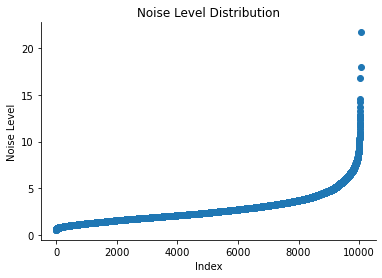

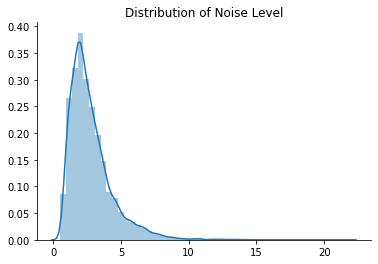

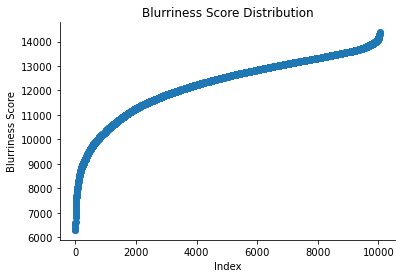

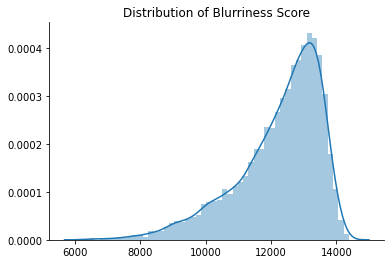

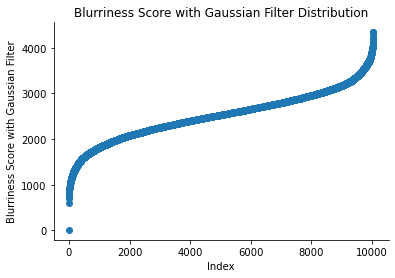

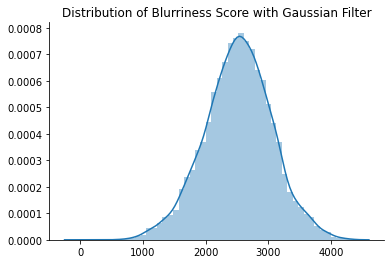

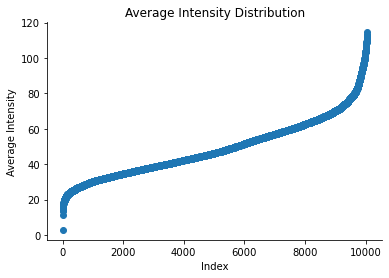

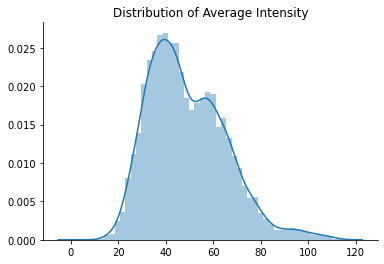

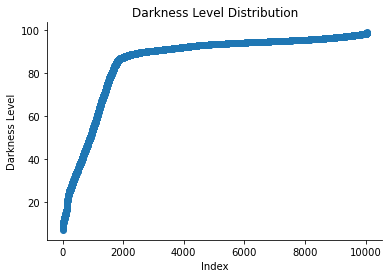

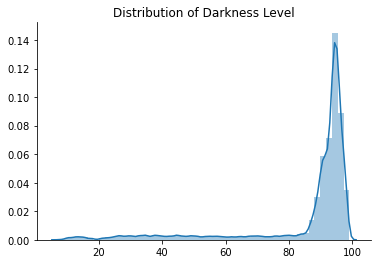

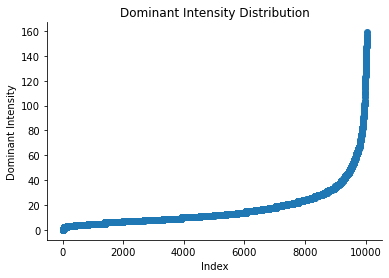

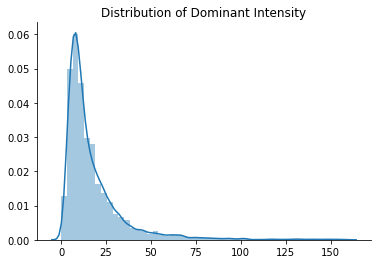

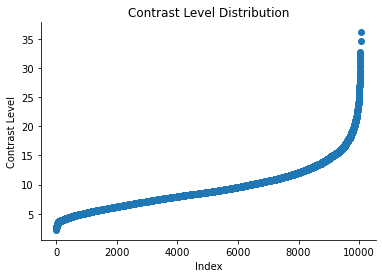

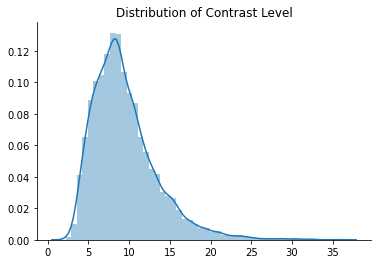

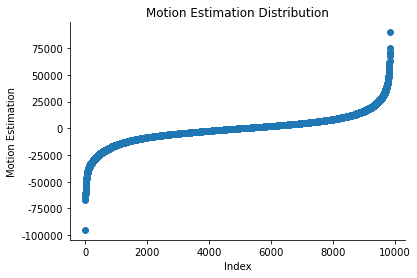

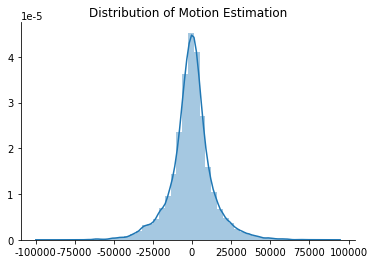

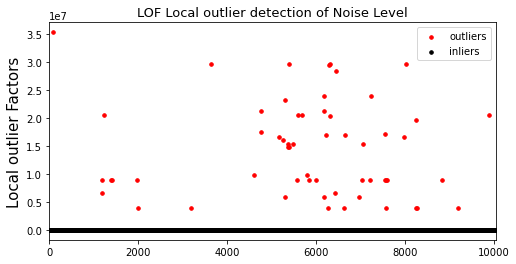

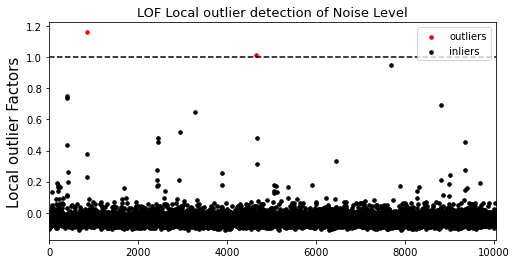

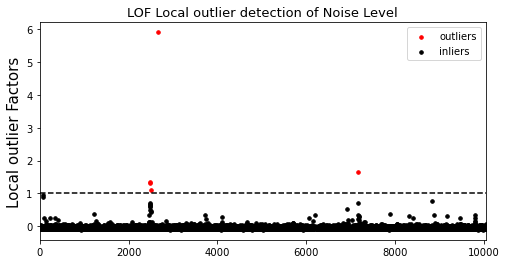

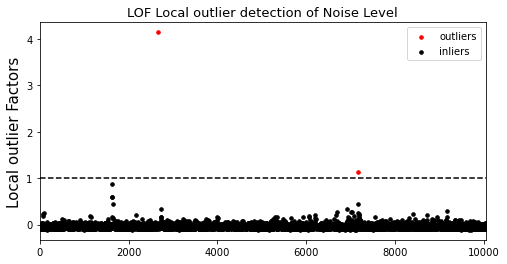

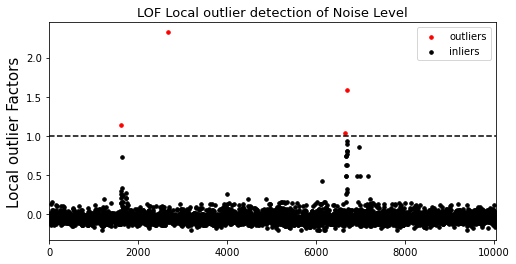

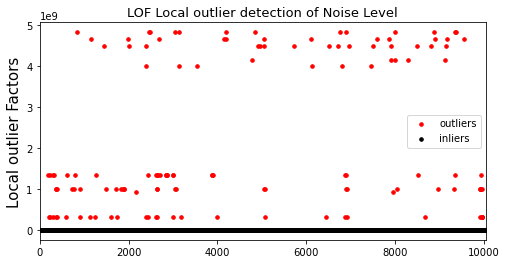

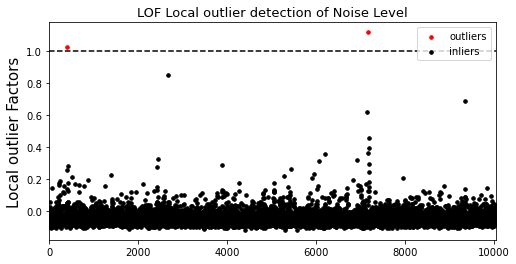

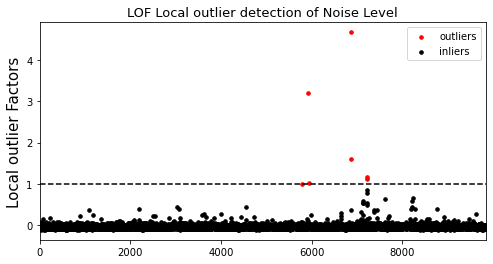

                 0   k distances  local outlier factor
5776  69350.986782  18874.574196              1.006228
5936 -66257.607443  16897.889759              1.027784
7216 -67225.948804  17866.231120              1.121348
7224  71150.297891  20584.081949              1.157939
6856  75559.072833  24992.856891              1.606160
5927  89939.366138  39373.150196              3.203695
6857 -95133.233566  45542.336867              4.670865


In [20]:
   
if __name__ == '__main__':
    # load images
    # C:/Users/Hzhang/Desktop/phd/data/images/
    folder = "C:/Users/Hzhang/Pictures/ACR"
    nl, bs, bs2, ai, dl, di, cl, mz = _get_measurements(folder)
    values = ((nl, 'Noise Level'), (bs, 'Blurriness Score'), (bs2, 'Blurriness Score with Gaussian Filter'),
              (ai, 'Average Intensity'), (dl, 'Darkness Level'), (di, 'Dominant Intensity'), (cl, 'Contrast Level'),
              (mz, 'Motion Estimation'))
    skew_kurt(values)
    figure(values)
    outliers = anomaly_score2(values)
    #grapped_outliers = grabbing_outliers(outliers, folder)
    #dropped_outliers = dropping_outliers(grapped_outliers)
    #print(values)
    print(outliers)
    # Save outliers's list
    with open("file.txt", "w") as f:
        for s in dropped_outliers:
            f.write(str(s) + "\n")


              0  k distances  local outlier factor
3287  14.544819     4.039849          1.077942e+00
9353  16.821945     6.126302          2.156249e+00
392   18.048429     7.352786          2.771715e+00
9354  21.729022    11.033379          4.759082e+00
7588   1.308800     0.006653          3.901240e+06
...         ...          ...                   ...
8033   1.032595     0.004870          2.961821e+07
6323   1.032595     0.004870          2.961821e+07
5388   1.032595     0.004870          2.961821e+07
3629   1.032595     0.004870          2.961821e+07
90     1.042335     0.004870          3.534688e+07

[62 rows x 3 columns]


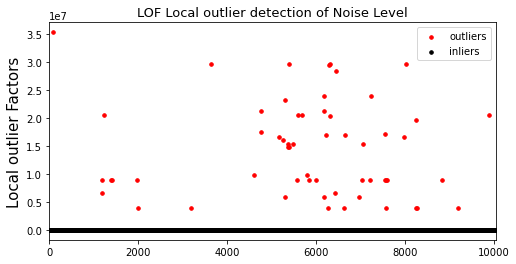

detected outliers of Noise Level: 
[3287, 9353, 392, 9354, 7588, 8251, 6282, 6641, 3185, 9205, 1991, 8273, 6183, 6969, 5303, 6437, 1192, 6014, 1392, 7546, 7595, 1976, 7037, 5579, 5852, 7569, 1193, 8845, 7223, 1416, 4614, 5801, 5386, 5375, 7057, 5480, 5377, 5249, 5177, 7994, 6219, 6653, 7548, 4764, 8253, 6317, 9895, 1221, 5686, 5587, 4760, 6193, 5300, 6191, 7250, 6450, 6301, 8033, 6323, 5388, 3629, 90]
                 0  k distances  local outlier factor
4657  14365.020406   190.415554              1.014636
850   14378.918096   204.313244              1.160525


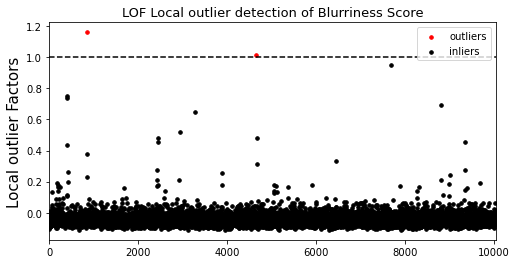

detected outliers of Blurriness Score: 
[4657, 850]
                0  k distances  local outlier factor
2498  4299.860953   315.427833              1.116245
2491  4338.537278   354.104159              1.332565
2492  4340.347781   355.914662              1.343451
7172   594.075439   408.199976              1.666520
2665     9.994099   991.487221              5.907547


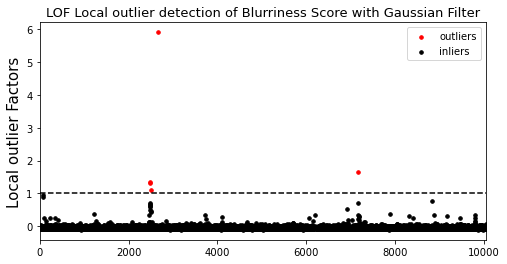

detected outliers of Blurriness Score with Gaussian Filter: 
[2498, 2491, 2492, 7172, 2665]
              0  k distances  local outlier factor
7172  11.016226     6.955654              1.137467
2665   2.868616    14.623490              4.142458


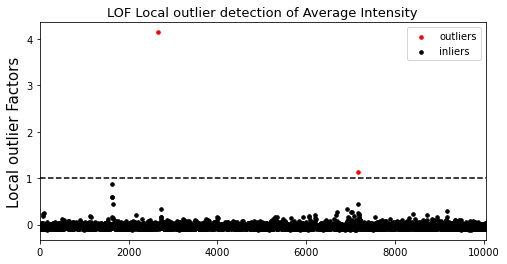

detected outliers of Average Intensity: 
[7172, 2665]
          0  k distances  local outlier factor
6664  98.92         0.31              1.037712
1621   7.21         3.67              1.143862
6710  99.04         0.43              1.580718
2665  99.17         0.56              2.323780


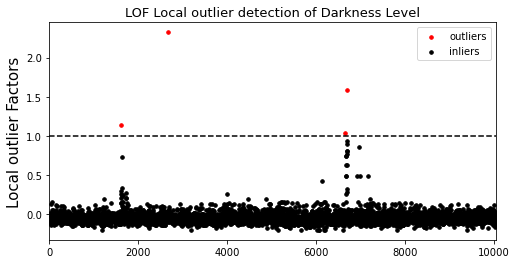

detected outliers of Darkness Level: 
[6664, 1621, 6710, 2665]
         0  k distances  local outlier factor
9958  42.0          1.0          3.277778e+08
9919  42.0          1.0          3.277778e+08
1254  42.0          1.0          3.277778e+08
1598  42.0          1.0          3.277778e+08
1734  42.0          1.0          3.277778e+08
...    ...          ...                   ...
8001   3.5          0.5          4.833333e+09
2459  21.5          0.5          4.833333e+09
3055  28.5          0.5          4.833333e+09
6760  36.5          0.5          4.833333e+09
8881  27.5          0.5          4.833333e+09

[134 rows x 3 columns]


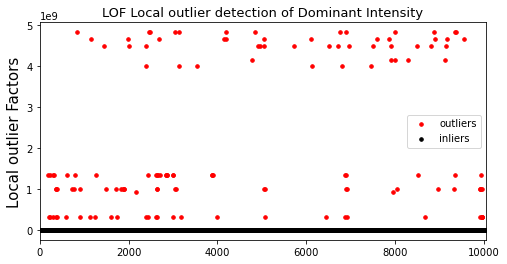

detected outliers of Dominant Intensity: 
[9958, 9919, 1254, 1598, 1734, 9956, 8670, 2403, 1123, 2441, 2614, 2636, 6883, 6434, 5068, 3992, 3012, 6906, 910, 3173, 381, 368, 203, 224, 9955, 298, 9951, 603, 2159, 7949, 364, 2632, 9946, 6899, 6908, 5062, 5053, 3038, 3078, 2640, 899, 9920, 378, 763, 9902, 1497, 739, 1726, 8050, 1834, 9925, 1909, 9321, 8961, 384, 1880, 1900, 6878, 6904, 9355, 3910, 8525, 3888, 9922, 198, 3882, 2709, 2666, 2854, 2869, 2871, 2637, 2613, 2445, 787, 615, 315, 3008, 3011, 310, 239, 1260, 2844, 2393, 6800, 7464, 3551, 3132, 6135, 4777, 9123, 8290, 8005, 7905, 6723, 1439, 9155, 2002, 8818, 6504, 8500, 4925, 2399, 7505, 4962, 6965, 7904, 5721, 5045, 4160, 4198, 1165, 6113, 9557, 2695, 1990, 7868, 8887, 5040, 7582, 9173, 9339, 4838, 9361, 2481, 3145, 6901, 838, 4205, 8001, 2459, 3055, 6760, 8881]
              0  k distances  local outlier factor
392   36.138970     8.274645              1.023370
7172   2.225918     0.902789              1.118404


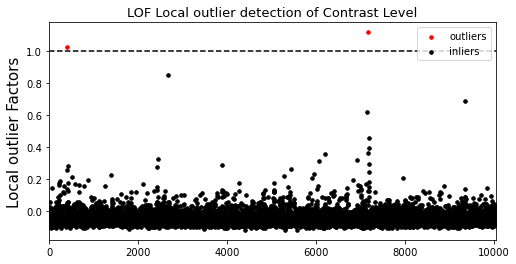

detected outliers of Contrast Level: 
[392, 7172]
                 0   k distances  local outlier factor
5776  69350.986782  18874.574196              1.006228
5936 -66257.607443  16897.889759              1.027784
7216 -67225.948804  17866.231120              1.121348
7224  71150.297891  20584.081949              1.157939
6856  75559.072833  24992.856891              1.606160
5927  89939.366138  39373.150196              3.203695
6857 -95133.233566  45542.336867              4.670865


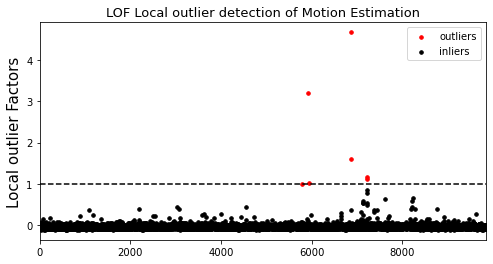

detected outliers of Motion Estimation: 
[5776, 5936, 7216, 7224, 6856, 5927, 6857]


In [74]:
outliers = anomaly_score2(values)